In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support



=== Data Preprocessing and Visualisation: TOP 1 only ===
TOP1: StandardScaler | proxy=0.7200




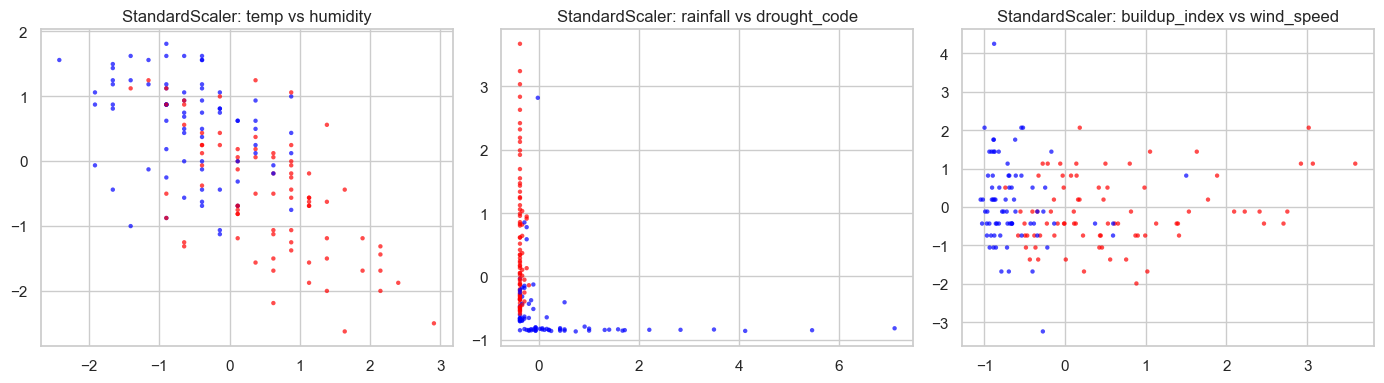

In [58]:

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

target_col = "fire"
feature_cols = ['year','temp','humidity','rainfall','drought_code','buildup_index','day','month','wind_speed']

def encode_target(v):
    return 1 if str(v).strip().lower() == "yes" else 0

y_train = df_train[target_col].apply(encode_target).values
y_test  = df_test[target_col].apply(encode_target).values
X_train = df_train[feature_cols].values
X_test  = df_test[feature_cols].values

# ========= (6 variantes) =========
preprocessings = [
    ("StandardScaler",  StandardScaler()),
    ("MinMaxScaler",    MinMaxScaler()),
    ("RobustScaler",    RobustScaler()),
    ("Normalizer",      Normalizer()),
    ("Norm+Standard",   None),  # Normalizer -> StandardScaler
    ("Norm+MinMax",     None),  # Normalizer -> MinMaxScaler
]

def apply_processing(name, proc, Xtr, Xte):
    if name == "Norm+Standard":
        norm = Normalizer().fit(Xtr)
        Xtr_n = norm.transform(Xtr); Xte_n = norm.transform(Xte)
        sc = StandardScaler().fit(Xtr_n)
        return sc.transform(Xtr_n), sc.transform(Xte_n)
    elif name == "Norm+MinMax":
        norm = Normalizer().fit(Xtr)
        Xtr_n = norm.transform(Xtr); Xte_n = norm.transform(Xte)
        sc = MinMaxScaler().fit(Xtr_n)
        return sc.transform(Xtr_n), sc.transform(Xte_n)
    else:
        sc = proc.fit(Xtr)
        return sc.transform(Xtr), sc.transform(Xte)

# Proxy “ preprocessing quality ” by linear SVM  on 2 features
def proxy_score(Xtr_p, ytr, Xte_p, yte, ix=feature_cols.index('temp'), iy=feature_cols.index('humidity')):
    if Xtr_p.shape[1] <= max(ix, iy):
        Xtr2 = Xtr_p[:, :2]; Xte2 = Xte_p[:, :2]
    else:
        Xtr2 = Xtr_p[:, [ix, iy]]; Xte2 = Xte_p[:, [ix, iy]]
    clf = SVC(kernel='linear', C=1.0)
    clf.fit(Xtr2, ytr)
    return accuracy_score(yte, clf.predict(Xte2))

# Évaluate and choose the TOP 1
scores = []
cache = {}
for name, proc in preprocessings:
    Xtr_p, Xte_p = apply_processing(name, proc, X_train, X_test)
    sc = proxy_score(Xtr_p, y_train, Xte_p, y_test)
    scores.append((name, sc))
    cache[name] = (Xtr_p, Xte_p)

scores.sort(key=lambda x: x[1], reverse=True)
best_name = scores[0][0]
print("\n=== Data Preprocessing and Visualisation: TOP 1 only ===")
print(f"TOP1: {best_name} | proxy={dict(scores)[best_name]:.4f}")
print("\n")
# Visualise only the top 1 (nuages de points)
Xtr_best, Xte_best = cache[best_name]
pairs = [('temp','humidity'), ('rainfall','drought_code'), ('buildup_index','wind_speed')]
def idx(col):
    return feature_cols.index(col) if Xtr_best.shape[1] >= len(feature_cols) else None

fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, (a,b) in zip(axes, pairs):
    ia, ib = idx(a), idx(b)
    if ia is not None and ib is not None:
        xa, xb = Xtr_best[:, ia], Xtr_best[:, ib]
    else:
        xa, xb = Xtr_best[:, 0], Xtr_best[:, 1]
    colors = np.where(y_train==1,'red','blue')
    ax.scatter(xa, xb, c=colors, s=10, alpha=0.7, edgecolor='none')
    ax.set_title(f"{best_name}: {a} vs {b}")
plt.tight_layout(); plt.show()

# ========= Impression: classification_report only =========
def print_report_only(y_true, y_pred):
    print(classification_report(y_true, y_pred, digits=2))

